In [1]:
import pickle
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## need to modify path_to_cyclegan
import sys
sys.path.append(os.path.abspath('XXX/path_to_cyclegan/XXX'))
from models import create_model
##

PATH_CHECKPOINTS =  os.path.abspath('../checkpoints/')

with open(PATH_CHECKPOINTS + '/simulation0_opt.p', 'rb') as reader:
    opt = pickle.load(reader)

In [2]:
opt.gpu_ids = [0]
opt.preprocess = 'resize'
opt.no_flip = True

In [3]:
model = create_model(opt)

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created


In [4]:
with open(PATH_CHECKPOINTS + '/pix2pix_deblur_opt.p', 'rb') as reader:
    opt_p2p = pickle.load(reader)
    
opt.preprocess = 'resize'
opt.no_flip = True
opt_p2p.gpu_ids = [0]
opt_p2p.checkpoints_dir = PATH_CHECKPOINTS

from models import create_model
model_p2p = create_model(opt_p2p)

model_p2p.load_networks(30)
model_p2p.eval()

initialize network with normal
initialize network with normal
model [Pix2PixModel] was created
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/pix2pix_deblur/30_net_G.pth
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/pix2pix_deblur/30_net_D.pth


In [5]:
from PIL import Image
from data.base_dataset import get_transform
opt.preprocess = 'resize'
opt.no_flip = True
transforms = get_transform(opt, grayscale=False)

In [6]:
import os
fns = os.listdir('../simulations/test_img/')

/data1/users/hclee/hclee/py3_env/lib/python3.5/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


simulation0
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation0/40_net_G_A.pth
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation0/40_net_G_B.pth
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation0/40_net_D_A.pth
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation0/40_net_D_B.pth


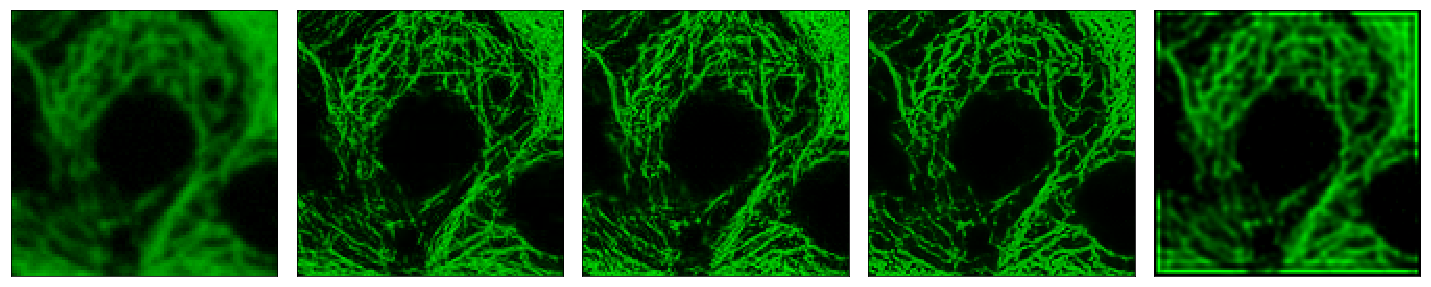

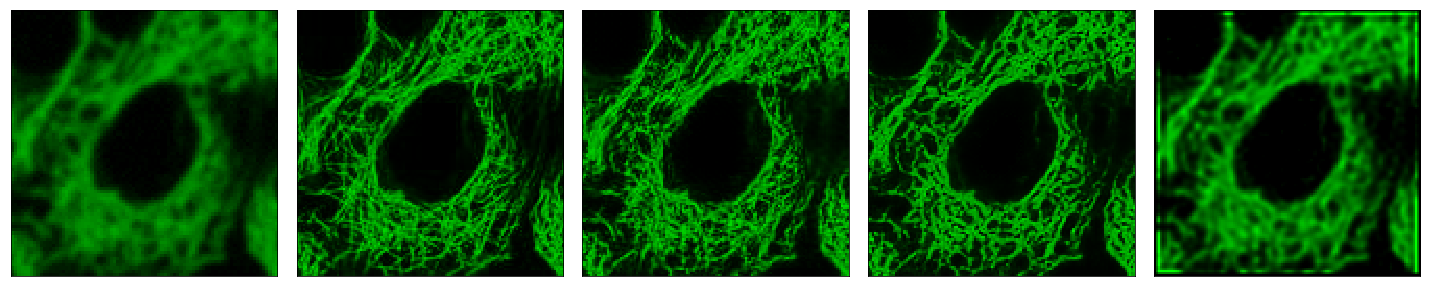

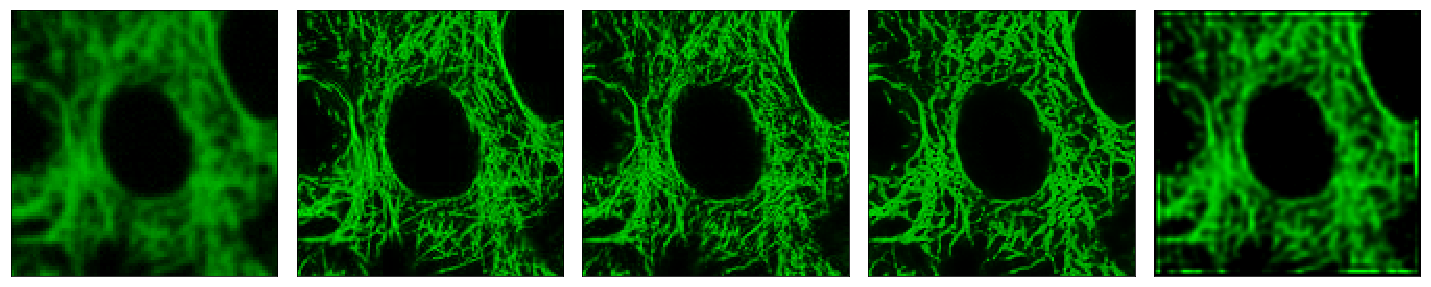

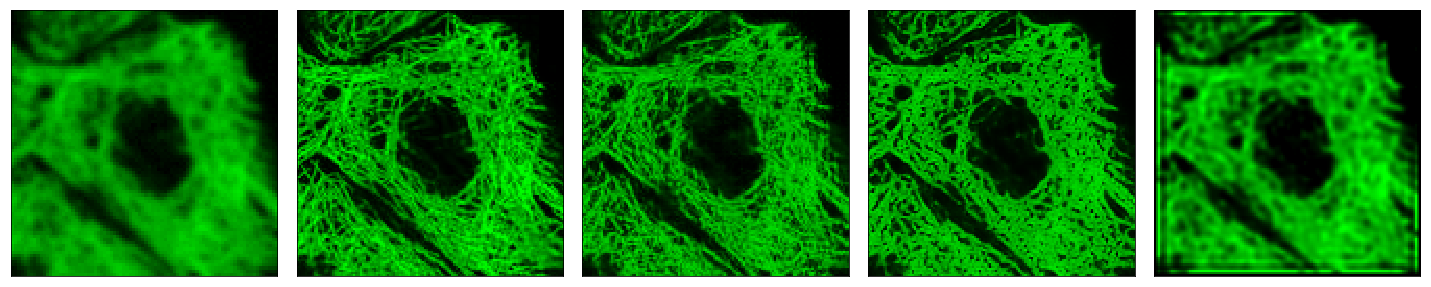

simulation1c
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation1c/40_net_G_A.pth
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation1c/40_net_G_B.pth
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation1c/40_net_D_A.pth
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation1c/40_net_D_B.pth


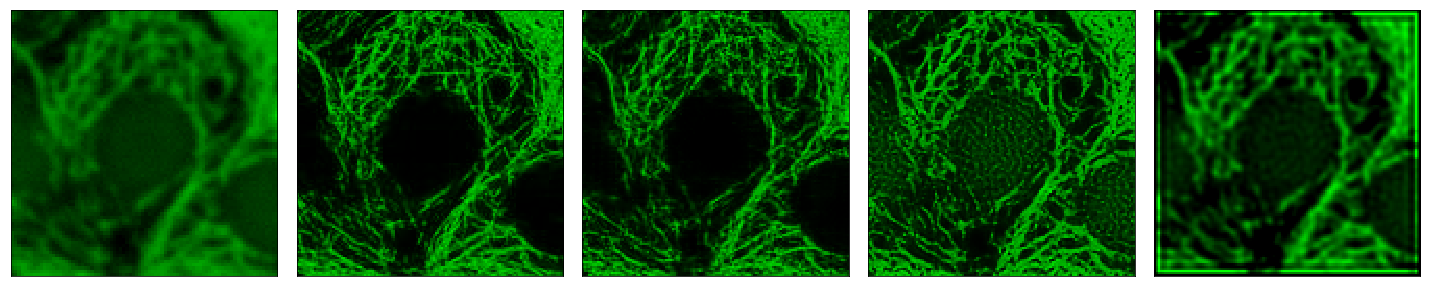

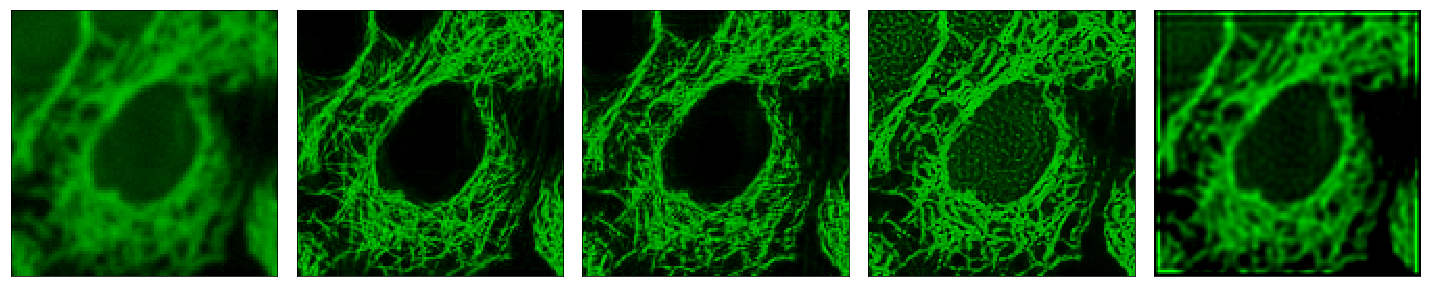

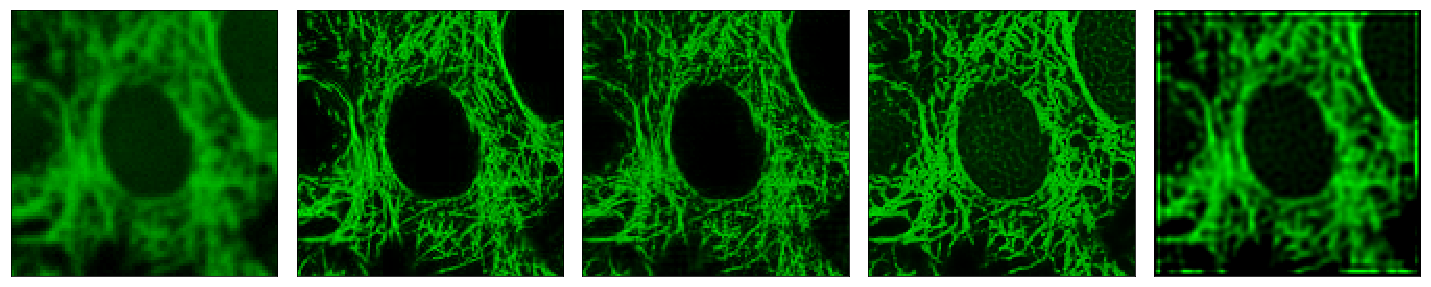

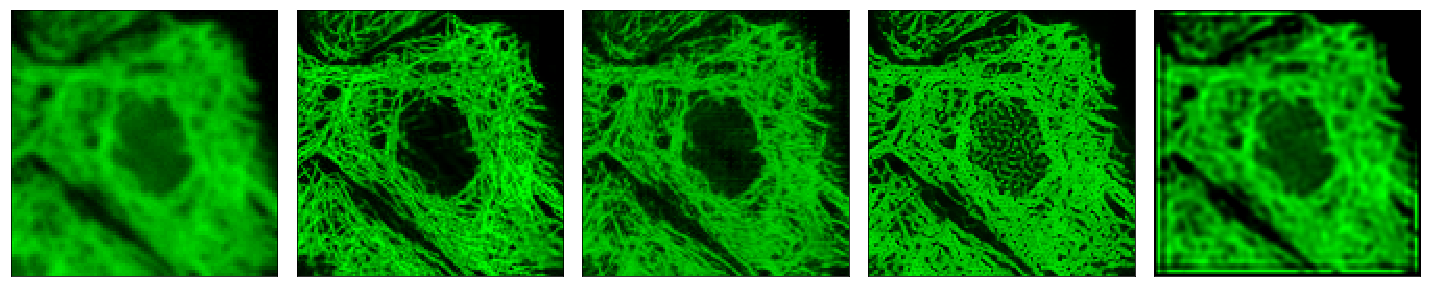

simulation2c
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation2c/40_net_G_A.pth
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation2c/40_net_G_B.pth
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation2c/40_net_D_A.pth
loading the model from /data1/users/hclee/git/widefield2confocal/checkpoints/simulation2c/40_net_D_B.pth


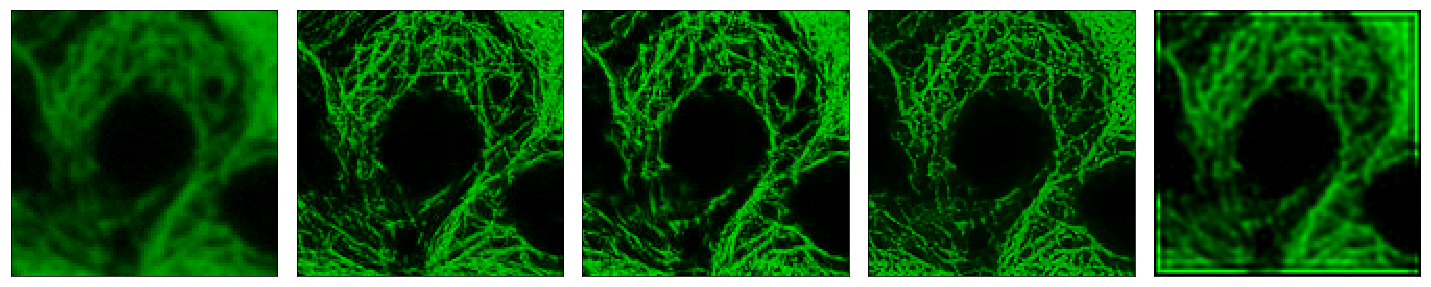

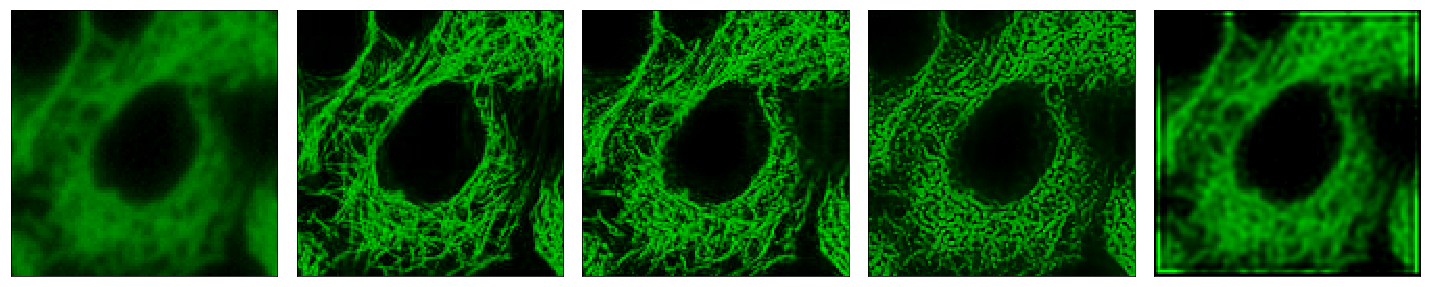

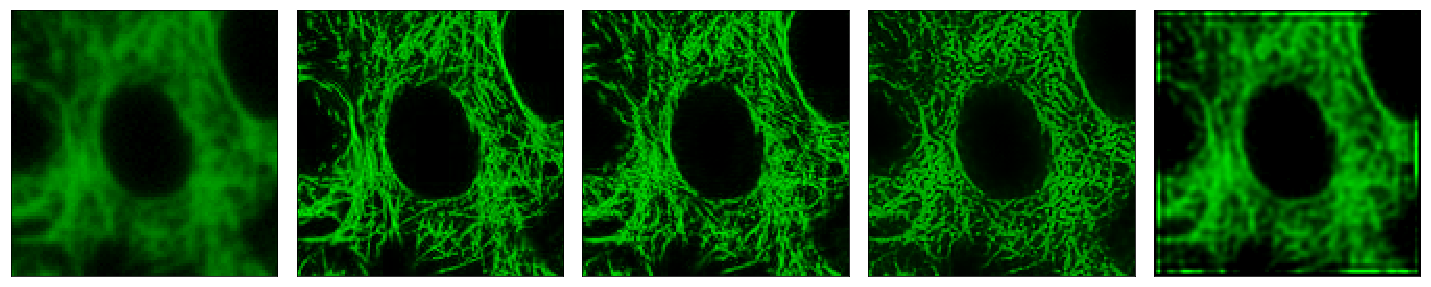

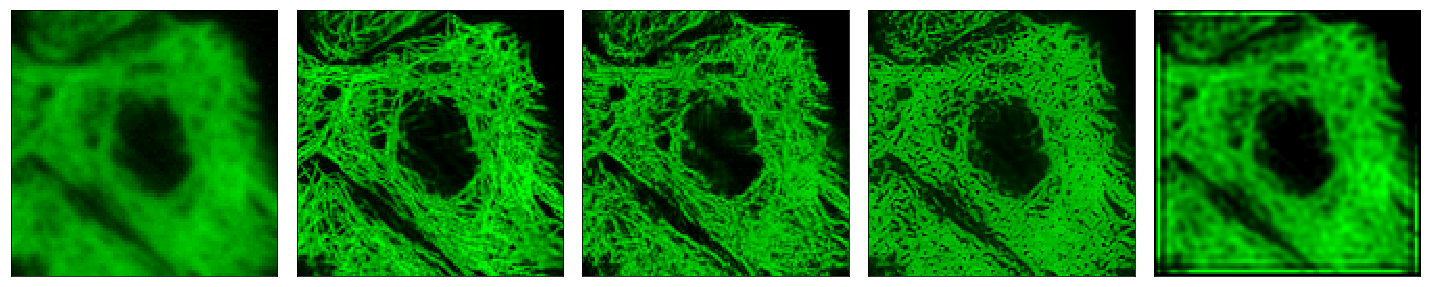

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import transform as skt
from skimage import filters as skf
from skimage.restoration import richardson_lucy
import numpy as np

psf = np.zeros((5, 5))
psf[2, 2] = 1.0
psf = skf.gaussian(psf, sigma = 1.0)
psf = psf / np.linalg.norm(psf)

res_all = {}
for exp in ['simulation0', 'simulation1c', 'simulation2c']:
    
    print(exp)
    
    res_ssim = []
    res_mssim = []
    res_roc = []
    
    model.save_dir = os.path.join(PATH_CHECKPOINTS, exp) 
    model.load_networks(40)
    model.eval()
    
    for f in fns[:4]:
        img0 = Image.open('../simulations/%s/test/%s' % (exp, f)).convert('RGB')
        img1 = Image.open('../simulations/%s/test/%s' % (exp, f))
        img1 = np.array(img1)
        img2 = Image.open('../simulations/test_img/%s' % f)
        img2 = np.array(img2)[:, :, 1]

        imgr_rl = img1.astype('float') / 255.
        imgr_rl = richardson_lucy(imgr_rl, psf, iterations=30)
        imgr_rl = skt.resize(imgr_rl, (128, 128), mode='constant', anti_aliasing=True)


        imgr_rl = (imgr_rl - np.mean(imgr_rl)) / (np.std(imgr_rl) + 1e-7 ) * np.std(img2) + np.mean(img2)
        imgr_rl = np.maximum(np.minimum(np.round(imgr_rl), 255), 0).astype(np.uint8)

        img = transforms(img0)[1]
        img = img.view([1, 1, 128, 128]).cuda()

        imgr_net = model.netG_A(img)
        imgr_net = (imgr_net + 1.0) * 127.5
        imgr_net = imgr_net.cpu().detach().numpy()[0, 0, :, :] 
        imgr_net = np.maximum(np.minimum(np.round(imgr_net), 255), 0).astype(np.uint8)

        imgr_p2p = model_p2p.netG(img)

        imgr_p2p = (imgr_p2p + 1.0) * 127.5
        imgr_p2p = imgr_p2p.cpu().detach().numpy()[0, 0, :, :] 
        imgr_p2p = np.maximum(np.minimum(np.round(imgr_p2p), 255), 0).astype(np.uint8)
    
        fig, axes = plt.subplots(1, 5, figsize = (20, 4))
        ax = axes[0]
        
        img = np.tile(img1[:, :, np.newaxis], [1, 1, 3])
        img[:, :, 0] = 0
        img[:, :, 2] = 0
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        
        
        img = np.tile(img2[:, :, np.newaxis], [1, 1, 3])
        img[:, :, 0] = 0
        img[:, :, 2] = 0  
        ax = axes[1]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

        img = np.tile(imgr_net[:, :, np.newaxis], [1, 1, 3])
        img[:, :, 0] = 0
        img[:, :, 2] = 0    
        ax = axes[2]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

        img = np.tile(imgr_p2p[:, :, np.newaxis], [1, 1, 3])
        img[:, :, 0] = 0
        img[:, :, 2] = 0        
        ax = axes[3]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        
        img = np.tile(imgr_rl[:, :, np.newaxis], [1, 1, 3])
        img[:, :, 0] = 0
        img[:, :, 2] = 0        
        ax = axes[4]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])    
        plt.tight_layout()
        plt.show()
